VAE - Pawsitive Aging
==============
The following code was heavily based upon the Keras VAE implmentation code with changes to the architecture and optimizations 

In [343]:
# library includes
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

In [344]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [345]:
# data loading from CSV
data_path = "./data_sources/"
processedDogs_path = "./data_sources/images/processed_dogs_sample/"
data_csv_path = "./data_sources/dog_data.csv"

dogCSV = pd.read_csv(data_csv_path)

dogImagesPaths = []
for fileDirectory in dogCSV["fileDirectory"]:
    dogImagesPaths.append(processedDogs_path + fileDirectory)

dogCSV["fullFilePath"] = dogImagesPaths

# removing all the rows that are labeled other than "middle-aged", "old", "young"
properLabels = ["old", "young", "middle-aged"]
dogCSV = dogCSV[dogCSV["label"].isin(properLabels)]
dogCSV


,index,fileDirectory,label,fullFilePath
0,0,dog000000.jpg,middle-aged,./data_sources/images/processed_dogs_sample/do...
1,1,dog000001.jpg,young,./data_sources/images/processed_dogs_sample/do...
2,2,dog000002.jpg,middle-aged,./data_sources/images/processed_dogs_sample/do...
3,3,dog000003.jpg,young,./data_sources/images/processed_dogs_sample/do...
4,4,dog000004.jpg,middle-aged,./data_sources/images/processed_dogs_sample/do...
...,...,...,...,...
59,59,dog000059.jpg,middle-aged,./data_sources/images/processed_dogs_sample/do...
60,60,dog000060.jpg,middle-aged,./data_sources/images/processed_dogs_sample/do...
61,61,dog000061.jpg,middle-aged,./data_sources/images/processed_dogs_sample/do...
62,62,dog000062.jpg,young,./data_sources/images/processed_dogs_sample/do...


In [346]:
# data preprocessing
loaded_images = []
r_data = []
g_data = []
b_data = []

for imageFilePath in dogCSV["fullFilePath"]:
    img = load_img(imageFilePath, target_size=(150, 150), color_mode='rgb')
    img_array = img_to_array(img) / 255.0
    imageData = np.array(img_array)
    loaded_images.append(imageData)
    r_data.append(np.array(imageData[:, :, 0]).flatten())
    g_data.append(np.array(imageData[:, :, 1]).flatten())
    b_data.append(np.array(imageData[:, :, 2]).flatten())    
    
dogCSV["RGB_data"] = loaded_images
dogCSV["R_data"] = r_data
dogCSV["G_data"] = g_data
dogCSV["B_data"] = b_data

dogCSV

,index,fileDirectory,label,fullFilePath,RGB_data,R_data,G_data,B_data
0,0,dog000000.jpg,middle-aged,./data_sources/images/processed_dogs_sample/do...,"[[[0.023529412, 0.05490196, 0.105882354], [0.0...","[0.023529412, 0.023529412, 0.023529412, 0.0274...","[0.05490196, 0.05490196, 0.05490196, 0.0549019...","[0.105882354, 0.105882354, 0.105882354, 0.1176..."
1,1,dog000001.jpg,young,./data_sources/images/processed_dogs_sample/do...,"[[[0.16078432, 0.25882354, 0.17254902], [0.137...","[0.16078432, 0.13725491, 0.14901961, 0.1882353...","[0.25882354, 0.23921569, 0.2509804, 0.29411766...","[0.17254902, 0.14117648, 0.14509805, 0.1725490..."
2,2,dog000002.jpg,middle-aged,./data_sources/images/processed_dogs_sample/do...,"[[[0.32156864, 0.078431375, 0.13725491], [0.32...","[0.32156864, 0.32156864, 0.32156864, 0.3098039...","[0.078431375, 0.078431375, 0.07058824, 0.05882...","[0.13725491, 0.13725491, 0.13333334, 0.1215686..."
3,3,dog000003.jpg,young,./data_sources/images/processed_dogs_sample/do...,"[[[1.0, 0.99607843, 1.0], [0.9529412, 0.933333...","[1.0, 0.9529412, 1.0, 0.9490196, 0.9843137, 1....","[0.99607843, 0.93333334, 0.99215686, 0.9137255...","[1.0, 0.9490196, 1.0, 0.93333334, 0.95686275, ..."
4,4,dog000004.jpg,middle-aged,./data_sources/images/processed_dogs_sample/do...,"[[[0.24313726, 0.2509804, 0.24705882], [0.2352...","[0.24313726, 0.23529412, 0.24705882, 0.3137255...","[0.2509804, 0.24313726, 0.2509804, 0.3019608, ...","[0.24705882, 0.23137255, 0.23137255, 0.2745098..."
...,...,...,...,...,...,...,...,...
59,59,dog000059.jpg,middle-aged,./data_sources/images/processed_dogs_sample/do...,"[[[0.16078432, 0.16470589, 0.18431373], [0.160...","[0.16078432, 0.16078432, 0.15686275, 0.1529411...","[0.16470589, 0.16470589, 0.16078432, 0.1568627...","[0.18431373, 0.18431373, 0.18039216, 0.1764706..."
60,60,dog000060.jpg,middle-aged,./data_sources/images/processed_dogs_sample/do...,"[[[0.23137255, 0.21176471, 0.22745098], [0.478...","[0.23137255, 0.47843137, 0.5372549, 0.3764706,...","[0.21176471, 0.4627451, 0.52156866, 0.35686275...","[0.22745098, 0.4509804, 0.47843137, 0.27058825..."
61,61,dog000061.jpg,middle-aged,./data_sources/images/processed_dogs_sample/do...,"[[[0.5254902, 0.5254902, 0.5176471], [0.525490...","[0.5254902, 0.5254902, 0.5254902, 0.5254902, 0...","[0.5254902, 0.5254902, 0.5254902, 0.5254902, 0...","[0.5176471, 0.5176471, 0.5176471, 0.5176471, 0..."
62,62,dog000062.jpg,young,./data_sources/images/processed_dogs_sample/do...,"[[[0.34901962, 0.36078432, 0.28627452], [0.270...","[0.34901962, 0.27058825, 0.19215687, 0.1254902...","[0.36078432, 0.28235295, 0.20392157, 0.1372549...","[0.28627452, 0.20784314, 0.13725491, 0.0705882..."


In [347]:
# splitting the test set and training set (25% test set, 75% training set)
imagesData = dogCSV["RGB_data"]
imageLabels = dogCSV["label"]

imageArr = []
for imageData in imagesData[0:64].to_list():
    imageArr.append(imageData)
X_train_tensor = tf.convert_to_tensor(imageArr)

In [348]:
X_train_tensor.shape

TensorShape([64, 150, 150, 3])

In [349]:
labels = dogCSV['label']

# enumerating and mapping the labels to values
labelDictionary = {"middled-aged":0, "old":1, "young":2}
labels_int = labels.map(labelDictionary).to_numpy()

num_classes = len(labelDictionary)  # Should be 3 in this case (young, middle-aged, old)
one_hot_labels = to_categorical(labels_int, num_classes)

# Output the one-hot encoded labels
print("One-hot encoded labels:")
print(one_hot_labels)

One-hot encoded labels:
[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


/Users/a17789/anaconda3/lib/python3.11/site-packages/keras/src/utils/numerical_utils.py:77: RuntimeWarning: invalid value encountered in cast
  x = np.array(x, dtype="int64")


In [407]:
# defining the encoder
latent_dim = 10
inputShape = (150, 150, 3)

encoder_inputs = keras.Input(shape=inputShape)

label_inputs = keras.Input(shape=(num_classes,))

# Reshape the labels to match the image shape
reshaped_labels = layers.Reshape((1, 1, num_classes))(label_inputs)
tiled_labels = layers.Lambda(lambda x: tf.tile(x, [1, 150, 150, 1]))(reshaped_labels)

concatenated_inputs = layers.Concatenate()([encoder_inputs, tiled_labels])
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(concatenated_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=3, padding="same")(x)
x = layers.Conv2D(128, 5, activation="relu", strides=1, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model([encoder_inputs, label_inputs], [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_45      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_23          │ (None, 1, 1, 3)   │          0 │ input_layer_45[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_44      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 150, 150,  │          0 │ reshape_23[0][0]  │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 150, 150,  │          0 │ input_layer_44[0… │
│ (Concatenate)       │ 6)                │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 75, 75,    │      1,760 │ concatenate_16[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 25, 25,    │     18,496 │ conv2d_43[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 25, 25,    │    204,928 │ conv2d_44[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 80000)     │          0 │ conv2d_45[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 128)       │ 10,240,128 │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 64)        │      8,256 │ dense_49[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 10)        │        650 │ dense_50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 10)        │        650 │ dense_50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_14         │ (None, 10)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,474,868 (39.96 MB)

 Trainable params: 10,474,868 (39.96 MB)

 Non-trainable params: 0 (0.00 B)

In [408]:
# defining the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
latent_label_inputs = layers.Concatenate()([latent_inputs, label_inputs])
x = layers.Dense(25 * 25 * 64, activation="relu")(latent_label_inputs)
x = layers.Reshape((25, 25, 64))(x)
x = layers.Conv2DTranspose(128, 5, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=3, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model([latent_inputs, label_inputs], decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_45      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 13)        │          0 │ input_layer_46[0… │
│ (Concatenate)       │                   │            │ input_layer_45[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 40000)     │    560,000 │ concatenate_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_24          │ (None, 25, 25,    │          0 │ dense_51[0][0]    │
│ (Reshape)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_81 │ (None, 25, 25,    │    204,928 │ reshape_24[0][0]  │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_82 │ (None, 75, 75,    │     73,792 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_83 │ (None, 150, 150,  │     18,464 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_84 │ (None, 150, 150,  │        867 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 858,051 (3.27 MB)

 Trainable params: 858,051 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

In [409]:
# defining the VAE class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        print(data)
        inputs, labels = data[0]
        print(inputs.shape)
        print(labels.shape)

    
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([inputs, labels])
            reconstruction = self.decoder([z, labels])
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(inputs, reconstruction),
                   axis=(1, 2),
               )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
    
        # Calculate gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
    
        #   Update the model weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
    
        # Return the metrics
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
        
        
    def getPredictions(self, inputs, labels):
        imageSize = 150
        z_mean, z_log_var, z = self.encoder.predict([inputs, labels], verbose = 0)
        decodedImage = self.decoder.predict([z, labels], verbose = 0)
        return decodedImage

In [410]:
#dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, one_hot_labels))
print("Inputs shape:", X_train_tensor.shape)
print("Labels shape:", one_hot_labels.shape)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit((X_train_tensor, one_hot_labels), epochs=20, batch_size=20)
vae.fit([X_train_tensor, one_hot_labels], epochs=20, batch_size=20)
vae.fit([X_train_tensor, one_hot_labels], epochs=20, batch_size=20)
vae.fit([X_train_tensor, one_hot_labels], epochs=20, batch_size=20)
vae.fit([X_train_tensor, one_hot_labels], epochs=20, batch_size=20)

Inputs shape: (64, 150, 150, 3)
Labels shape: (64, 3)
Epoch 1/20
((<tf.Tensor 'data:0' shape=(None, 150, 150, 3) dtype=float32>, <tf.Tensor 'data_1:0' shape=(None, 3) dtype=float32>),)
(None, 150, 150, 3)
(None, 3)
((<tf.Tensor 'data:0' shape=(None, 150, 150, 3) dtype=float32>, <tf.Tensor 'data_1:0' shape=(None, 3) dtype=float32>),)
(None, 150, 150, 3)
(None, 3)
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - kl_loss: 17.9249 - loss: 15609.6367 - reconstruction_loss: 15591.0146 - total_loss: 15606.1426
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - kl_loss: 0.0310 - loss: 15577.1436 - reconstruction_loss: 15578.3799 - total_loss: 15583.4795
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - kl_loss: 0.1395 - loss: 15569.1748 - reconstruction_loss: 15571.0283 - total_loss: 15579.1406
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - kl_loss: 0.6844 - loss: 15572.7881 - reconstruction_loss: 15571.9707 - total_loss: 15572.1240
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - kl_loss: 

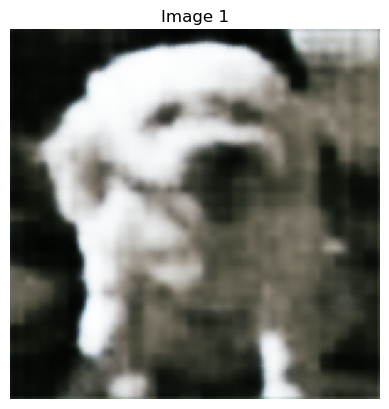

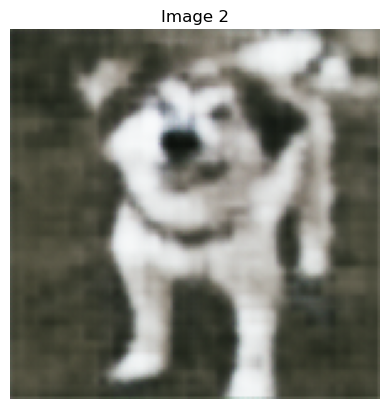

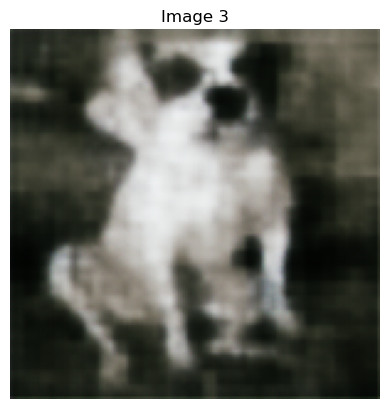

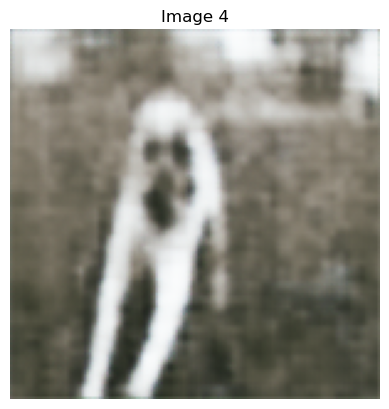

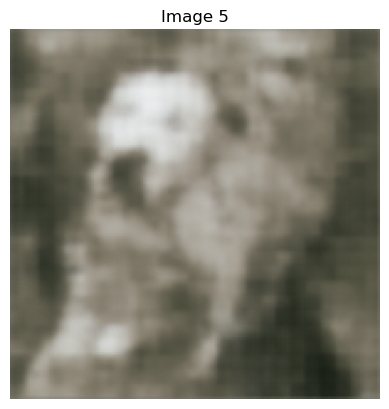

In [412]:
x_decoded = vae.getPredictions(X_train_tensor, one_hot_labels)
# Define the number of images you want to display
num_images = 5

# Define the starting index
start_index = 0

# Loop to display multiple images
for i in range(start_index, start_index + num_images):
    # Get the decoded image at the current index
    predicted_image = x_decoded[i].reshape(150, 150, 3)
    
    # Plot the image
    plt.figure()
    plt.imshow(predicted_image)
    plt.axis('off')
    plt.title(f"Image {i + 1}")
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


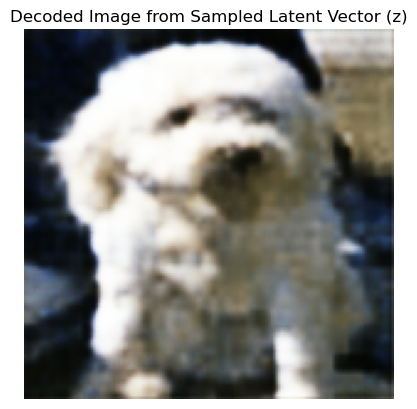

In [ ]:
# Get the predicted values from the encoder
z_mean, z_log_var, z = encoder.predict(X_train_tensor)

# Decode the sampled latent vector (z) and visualize the image
decoded_image = decoder.predict(z)

# Display the first decoded image
plt.figure()
plt.imshow(decoded_image[0].reshape(150, 150, 3))
plt.axis('off')
plt.title("Decoded Image from Sampled Latent Vector (z)")
plt.show()

In [ ]:
X_train_tensor.shape

TensorShape([64, 150, 150, 3])

In [415]:
# try for first image
original_image_np = X_train_tensor[0].numpy()
original_label_np = one_hot_labels[0]

# Reshape the numpy array
original_image_np = original_image_np.reshape(1, 150, 150, 3)

# Obtain the original latent vector representation from the encoder
z_mean, z_log_var, original_latent_vector = encoder.predict(original_image_np, original_label_np)

noise = np.random.normal(scale=0.1, size=original_latent_vector.shape)
modified_latent_vector = original_latent_vector + noise

generated_image = decoder.predict(original_latent_vector)
modified_generated_image = decoder.predict(modified_latent_vector)

# create completely random

# show original and noisy image decoded
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(original_image_np[0]) 
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(generated_image.reshape(150, 150, 3))  
plt.axis('off')
plt.title("generate image")

plt.subplot(1, 3, 3)
plt.imshow(modified_generated_image.reshape(150, 150, 3))  
plt.axis('off')
plt.title("Modified image")

plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()